In [1]:

from collections import defaultdict
import csv 
from csv import reader
from scipy.optimize import linear_sum_assignment
#from PIL import Image as im
from IPython.core.display import Image, display
import requests
from io import BytesIO
import json 

'''
Ambiguity
    Multiple Options > A/M
    Definition, Location > A/L
    Definition, Destination/Intention > A/D
    Definition, Kind/Type > A/K
    Definition, Time > A/T
    Gouping > A/G

Uncertainty > U

Mistakes/Bad Data
    Annotator mistakes > M/A
    Bad question/bad images > M/B

Misc/need reclassifying > ~

Question with multiple classification will have '.' between the classificiations
ex: A/M.A/L.M/B)
'''

input_csv = "../../jimena_work/cleaned_data/csv/consolidate_data_repeat_all_data.csv"
data = []
with open(input_csv) as read_obj:
    csv_reader = csv.DictReader(read_obj)
    for row in csv_reader:
        data.append(row)



<ipython-input-1-d91ca9447c0c>:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
'''
Display by number of classifications
'''
search_num = 3

for row in data:

    temp = row['Answer.skip_reason'].strip('"')
    labels = temp.split('.')
    
    if len(labels) >= search_num:
        groups = []

        new_questions = json.loads(row['Answer.answer_questions'])
        for i, g in enumerate(json.loads(row['Answer.answer_groups'])):
            group = []
            new_question = new_questions[i]
            for x in g:
                group.append(x['content'])
            groups.append({new_question: group})
        print(row['Input.questionStr'])
        print(row['Input.imgUrl'])
        print(groups)
        print(labels)

        image_url = row['Input.imgUrl'].strip('"')
        display(Image(url=image_url))

excepted: ['skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', '', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip', 'skip']
num of A/C: 24
num of A/P: 16


/brtx/601-nvme1/estengel/miniconda3/envs/cert/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


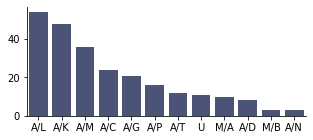

In [5]:
import seaborn as sns 
from matplotlib import pyplot as plt 
import numpy as np 
from collections import Counter
import pandas as pd 

# define a nice color palette 
palette = ["#212E52", "#444E7E", "#8087AA", "#B7ABBC", "#F9ECE8", "#FCC893", "#FEB424", "#FD8700", "#D8511D"]

# Histogram
num_mistakes_other = 0
num_to_keep = 0
total = 0

# same data as from csv 
histogram_data = data

# list of acceptable labels 
acceptable = ['A/L', 'A/K', 'A/M', 'A/D', 'A/G', 'A/C', 'A/P', 'A/N', 'A/T', 'M/A', 'M/B', 'misc', 'U']
# list of labels to keep 
to_keep = ['A/M', 'A/G', 'A/D', 'A/K', 'A/T', 'A/C', 'A/P', 'A/N', 'A/L']

all_labels = []
excepted = []
# go through rows, find acceptable labels, add to a list for counter and for histogram 
for row in data:
     temp = row['ambiguity_type'].strip('"').strip("\\").strip('"').strip(' ')
     labels = temp.split('.')
     for lab in labels:
          lab = lab.strip()
          if lab in acceptable:
               all_labels.append(lab)
          else: 
               # inspect these 
               excepted.append(lab) 
     for lab in labels:
          lab = lab.strip()
          if lab in to_keep: 
               num_to_keep += 1 
               break
          else:
               num_mistakes_other  += 1
               break

# make a plot object 
fig, ax = plt.subplots(1,1, figsize=(5,2))

# count up all the occurences of each label for getting an order 
acceptable_count = Counter(all_labels)
# define a sorted order 
order = sorted(acceptable_count.items(), key=lambda x: x[1], reverse=True)
order = [x[0] for x in order]

# plot the histogram 
g = sns.countplot(all_labels, order = order, color = palette[1], ax = ax)
sns.despine()
ax.set_ylabel("")

# save to file 
plt.savefig("/home/estengel/papers/vqa-ambiguity-2022/figures/ontology_histogram.pdf")

# make sure nothing is in there that shouldn't be 
print(f"excepted: {excepted}")


print(f"num of A/C: {sum([1 for x in all_labels if  'A/C' in x])}")
print(f"num of A/P: {sum([1 for x in all_labels if 'A/P' in x])}")

A/P and A/C: 11
A/P and A/C: 11


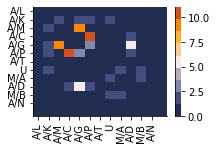

In [6]:
import seaborn as sns 
from matplotlib import pyplot as plt 
import numpy as np 
from collections import Counter
import pandas as pd 

# define a nice color palette 
palette = ["#212E52", "#444E7E", "#8087AA", "#B7ABBC", "#F9ECE8", "#FCC893", "#FEB424", "#FD8700", "#D8511D"]

# Histogram
num_mistakes_other = 0
num_to_keep = 0
total = 0

# same data as from csv 
histogram_data = data

# list of acceptable labels 
acceptable = ['A/L', 'A/K', 'A/M', 'A/D', 'A/G', 'A/C', 'A/P', 'A/N', 'A/T', 'M/A', 'M/B', 'misc', 'U']

# count up the coocurrence counts 
cooc_counter = defaultdict(lambda: defaultdict(int)) 
for row in data:
     temp = row['ambiguity_type'].strip('"').strip("\\").strip('"').strip(' ')
     labels = temp.split('.')
     for lab1 in labels:
        for lab2 in labels:
            if lab1 == lab2:
                continue
            cooc_counter[lab1][lab2] += 1
      
# turn into a matrix for plotting 
# use the order from previous cell to get order 
cooc_matrix = np.zeros((len(acceptable), len(acceptable)))
for i, lab1 in enumerate(order):
    for j, lab2 in enumerate(order):
        cooc_matrix[i][j] = cooc_counter[lab1][lab2]

# make a new plot
fig, ax = plt.subplots(1,1, figsize=(3,2))

g = sns.heatmap(cooc_matrix, cmap = palette, ax = ax, cbar = True, xticklabels = order, yticklabels = order)
sns.despine()

plt.savefig("/home/estengel/papers/vqa-ambiguity-2022/figures/ontology_heatmap.pdf")

print(f"A/P and A/C: {cooc_counter['A/P']['A/C']}")
print(f"A/P and A/C: {cooc_counter['A/C']['A/P']}")

['A/C-A/P', 'A/G-A/M', 'A/D-A/G', 'A/G-A/P', 'M/B-U', 'M/A-U', 'A/K-U', ' A/M-U', 'M/A-M/B', 'A/K-A/P', 'A/D-A/P', 'A/C-A/D', 'A/K-A/M', 'A/G-A/K']
['M/B-U', 'M/B-U', 'M/A-U', 'M/A-U', 'A/K-U', 'A/K-U', ' A/M-U', ' A/M-U', 'M/A-M/B', 'M/A-M/B', 'A/C-A/P', 'A/C-A/P', 'A/C-A/P', 'A/C-A/P', 'A/C-A/P', 'A/C-A/P', 'A/C-A/P', 'A/C-A/P', 'A/C-A/P', 'A/C-A/P', 'A/C-A/P', 'A/K-A/P', 'A/K-A/P', 'A/D-A/P', 'A/D-A/P', 'A/G-A/P', 'A/G-A/P', 'A/G-A/P', 'A/C-A/D', 'A/C-A/D', 'A/K-A/M', 'A/K-A/M', 'A/G-A/K', 'A/G-A/K', 'A/D-A/G', 'A/D-A/G', 'A/D-A/G', 'A/D-A/G', 'A/D-A/G', 'A/G-A/M', 'A/G-A/M', 'A/G-A/M', 'A/G-A/M', 'A/G-A/M', 'A/G-A/M', 'A/G-A/M', 'A/G-A/M', 'A/G-A/M']
num of A/C-A/P: 11


/brtx/601-nvme1/estengel/miniconda3/envs/cert/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


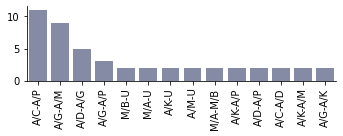

In [9]:
# try plotting as a histogram since there are very few that are non-zero 

done = []
to_plot_counts = []
for lab1, lab1_dist in cooc_counter.items():
    for lab2, count in lab1_dist.items():
        if (lab1, lab2) not in done and (lab2, lab1) not in done and count > 1:
            to_plot_counts += ['-'.join(sorted([lab1, lab2])) for i in range(count)]
            done.append((lab1, lab2))


# make a plot object 
fig, ax = plt.subplots(1,1, figsize=(5,2))

# count up all the occurences of each label for getting an order 
counts = Counter(to_plot_counts)
# define a sorted order 
order = sorted(counts.items(), key=lambda x: x[1], reverse=True)
order = [x[0] for x in order]

print(order)

print(to_plot_counts)
# plot the histogram 
g = sns.countplot(to_plot_counts, order = order, color = palette[2], ax = ax)
ax.set_xticklabels(order, rotation = 90)
sns.despine()
ax.set_ylabel("")
plt.tight_layout()

# save to file 
plt.savefig("/home/estengel/papers/vqa-ambiguity-2022/figures/ontology_cooc_histogram.pdf")


print(f"num of A/C-A/P: {sum([1 for x in to_plot_counts if  'A/C-A/P' in x])}")